<a href="https://colab.research.google.com/github/dkrieger94/intro/blob/master/EarthSystemModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.special import erf

import matplotlib.pyplot as plt

A = 204.                    # Budyko approximation constants (W / m**2)
B = 2.17

a = 5.4                     # constant for OLR modification by CO2 (W / m**2)

sigma = 5.6703726226e-08    # Stefan-Boltzmann constant (W / m**2 / K**4)
S0 = 1365.2                 # solar constant (W / m**2)
emss = 0.6                  # atmosphere emissivity

rho_w = 1028.               # density of water (kg / m**3)
cw = 4200.                  # specific heat of liquid water (J / kg / K)

# carbon cycle
co2 = 280.                  # pre-industrial atmospheric CO2 concentration (ppm)
g_e = 0.005                 # GtC/yr/ppm
zeta = 10.5                 
mu_0 = 5.                   # ocean carbon transfer rate (m / yr)
k_a = 2.12                  # GtC ppm^−1

tau_l = 41.                 # reference lifetime of land carbon (yr)
q_10 = 1.8                  # increase in respiration with a 10K temp. increase
beta_fertil = 0.4           # CO2 fertilization factor
npp_0 = 60.                 # pre-industrial net primary productivity (GtC / yr)
cl_0 = 2500.                # pre-industrial land carbon storage (GtC)

# Some useful time conversion factors
seconds_per_minute = 60.
minutes_per_hour = 60.
hours_per_day = 24.
days_per_year = 365.2422
seconds_per_hour = minutes_per_hour * seconds_per_minute
minutes_per_day = hours_per_day * minutes_per_hour
seconds_per_day = hours_per_day * seconds_per_hour
seconds_per_year = seconds_per_day * days_per_year


class ESM:

    def __init__(self,
                 initial_state={'Ts':255., 'Td':243.},
                 solar_cnst=0.25 * S0,
                 albedo_atm=0.1,
                 albedo_land=0.3,
                 albedo_icefree=0.2,
                 albedo_ice=0.6,
                 albedo_ref_temperature=273.15,
                 albedo_b=0.05,
                 albedo_carbon_coeff=-0.01,
                 emissivity=emss,
                 depth_s=50.0,
                 depth_d=3450.0,
                 emissions=36.,
                 transient_rad_resp=0.0,
                 mixing_scale=3.2,
                 lin_olr=False,
                 use_constant_albedo_land=False,
                 use_constant_albedo_icefree=False,
                 active_components=3):
      
        # albedo parameters
        self.albedo_atm = albedo_atm  # atmospheric albedo
        self.albedo_land = albedo_land
        self.albedo_icefree = albedo_icefree  # land albedo in hothouse climate
        self.albedo_ice = albedo_ice  # land albedo in snowball climate
        self.albedo_ref_temperature = albedo_ref_temperature  # reference temperature for albedo transition zone
        self.albedo_b = albedo_b  # albedo error function tuning parameter
        self.albedo_carbon_coeff = albedo_carbon_coeff  # albedo dependence on carbon
        self.use_constant_albedo_land = use_constant_albedo_land
        self.use_constant_albedo_icefree = use_constant_albedo_icefree

        self.solar_cnst = solar_cnst
        self.lin_olr = lin_olr

        # effective emissivity
        self.emss_cns = 1.0 - 0.5 * emissivity

        # atmosphere-ocean coupling parameters
        self.eta = mixing_scale
        self.lambda_t = transient_rad_resp

        # pre-industrial ocean carbon storage
        self.cl_0 = cl_0
        self.ca_0 = co2 * k_a
        self.co_0 = 6 * zeta * self.ca_0
        self.cs_0 = self.co_0 * (depth_s) / (depth_s + depth_d)
        self.cd_0 = self.co_0 - self.cs_0
        self.nu = zeta * (self.ca_0 / self.cs_0)

        # anthropogenic emissions
        self.em = emissions  # Anthropogenic emissions (GtC / yr)

        #-----------------------------------------------------------------------
        # Model state initialization:
        #-----------------------------------------------------------------------
        self.model_state = {}

        if isinstance(initial_state, dict):
            vnames = initial_state.keys()
            assert 'Ts' in vnames,"Model state must contain at least 'Ts'"

            self.model_state['Ts'] = initial_state['Ts']
            if 'Td' not in vnames:
                self.model_state['Td'] = initial_state['Ts'] - 10.0
            else:
                self.model_state['Td'] = initial_state['Td']

            if 'Ca' not in vnames: # Atmospheric   carbon storage (GtC)
                self.model_state['Ca'] = self.ca_0
            else: 
                self.model_state['Ca'] = initial_state['Ca'] * k_a

            if 'Cs' not in vnames: # Surface Ocean carbon storage (GtC)
                self.model_state['Cs'] = self.cs_0
            else:
                self.model_state['Cs'] = initial_state['Cs']

            if 'Cd' not in vnames: # Deep Ocean    carbon storage (GtC)
                self.model_state['Cd'] = self.cd_0
            else:
                self.model_state['Cd'] = initial_state['Cd']

            if 'Cl' not in vnames: # Terrestrial   carbon storage (GtC)
                self.model_state['Cl'] = self.cl_0
            else:
                self.model_state['Cl'] = initial_state['Cl']

        elif np.isscalar(initial_state):
            self.model_state['Ts'] = initial_state
            # ocean layer initialized to be 10 degrees colder than the surface layer
            self.model_state['Td'] = self.model_state['Ts'] - 10.0
            self.model_state['Ca'] = self.ca_0
            self.model_state['Cs'] = self.cs_0
            self.model_state['Cd'] = self.cd_0
            self.model_state['Cl'] = self.cl_0

        else:
            raise ValueError("Wrong model initialization")

        # create instances of state variables from init dictionary
        for k, v in self.model_state.items():
            setattr(self, k, v)

        self.num_active_components = active_components
        self.num_active_variables = np.array([1,2,6])[active_components-1]


        #-----------------------------------------------------------------------
        # Integration time scales
        #-----------------------------------------------------------------------
        self.depth_s = depth_s      # characteristic depth for Ts   (m)
        self.tau_s = self.depth_s * rho_w * cw # time scale for integration

        self.depth_d = depth_d      # characteristic depth for Ts   (m)
        self.tau_d = self.depth_d * rho_w * cw # time scale for integration

    #---------------------------------------------------------------------------
    #---------------   Definition Atmosphere-Ocean processes    ----------------
    #---------------------------------------------------------------------------
    def compute_albedo(self, Ts, Ca):
        return self.albedo_atm + self.compute_albedo_land(Ts, Ca) * (1 - self.albedo_atm) ** 2

    def compute_albedo_land(self, Ts, Ca):
        if self.use_constant_albedo_land:
            return self.albedo_land
        else:
            tmp = erf(self.albedo_b * (Ts - self.albedo_ref_temperature))
            tmp = self.albedo_ice * (1.0 - tmp) + self.compute_albedo_icefree(Ca) * (1.0 + tmp)
            return tmp / 2.0

    def compute_albedo_icefree(self, Ca):
        if self.use_constant_albedo_icefree:
            return self.albedo_icefree
        elif (Ca / k_a) > 1.0:
            return self.albedo_icefree + self.albedo_carbon_coeff * np.log(Ca / k_a)
        else:
            return self.albedo_icefree

    def compute_ASR(self, Ts, Ca):
        return self.solar_cnst * (1 - self.compute_albedo(Ts, Ca))

    def compute_OLR(self, Ts, Ca):
        if self.lin_olr:
            return A + B * (Ts - 273.15)
        if (Ca / k_a) > 1.0:
            return self.emss_cns * sigma * Ts ** 4 - a * np.log(Ca/k_a)
        else:
            return self.emss_cns * sigma * Ts ** 4

    def compute_NRI(self, Ts, Ca):
        return  self.compute_ASR(Ts, Ca) - self.compute_OLR(Ts, Ca)

    def compute_DSI(self, Ts, Td):
        return (self.eta + self.lambda_t) * (Ts - Td)

    #---------------------------------------------------------------------------
    #------------------           Carbon Cycle             ---------------------
    #---------------------------------------------------------------------------
    def gas_exchange_rate(self, Ts):
        return g_e

    def compute_fs(self, Ts, Ca, Cs):
        """Ocean carbon uptake
        """
        dCo = self.nu * (Cs - self.cs_0)
        return self.gas_exchange_rate(Ts) * ((Ca - self.ca_0) - dCo) / k_a

    def compute_fd(self, Cs, Cd):
        tmp_s = (Cs - self.cs_0) / self.depth_s
        tmp_d = (Cd - self.cd_0) / self.depth_d
        return mu_0 * (tmp_s - tmp_d)

    def compute_fl(self, Ca, Cl, Ts):
        return self.compute_NPP(Ca) - self.compute_respiration(Ts, Cl)

    def compute_NPP(self, Ca):
        return npp_0 * (1 + beta_fertil * np.log(Ca / self.ca_0))

    def compute_respiration(self, Ts, Cl):
        return Cl / tau_l * (q_10) ** (Ts / 10)


    #---------------------------------------------------------------------------
    #------------------   Model tendencies and components  ---------------------
    #---------------------------------------------------------------------------

    # Instead of evaluating conditional statement inside 'self.compute_imbalance',
    # the model is constructed according to the number of active components

    def model_constructor(self):

        if self.num_active_components == 1:

            def _compute_imbalance(state):
                return self.compute_NRI(state, self.Ca) / self.tau_s

        elif self.num_active_components == 2:

            def _compute_imbalance(state):
                Ts, Td = state
                Ns = self.compute_NRI(Ts, self.Ca) / self.tau_s
                Nd = self.compute_DSI(Ts, Td) / self.tau_d
                return np.array([Ns - Nd, Nd])

        elif self.num_active_components == 3:
            # self.ca is not a state variable unless emissions are considered
            def _compute_imbalance(state):
                Ts, Td, Cs, Cd, Cl, Ca = state
                Ns = self.compute_NRI(Ts, Ca) / self.tau_s
                Nd = self.compute_DSI(Ts, Td) / self.tau_d

                Ncs = self.compute_fs(Ts, Ca, Cs)
                Ncd = self.compute_fd(Cs, Cd)
                Ncl = self.compute_fl(Ca, Cl, Ts)

                return np.array([Ns - Nd, Nd, Ncs - Ncd, Ncd, Ncl, self.em - Ncl - Ncs])
        else:
            raise ValueError("Something went wrong when constructing the model")

        return _compute_imbalance

    #---------------------------------------------------------------------------
    #------------------          Model numerics            ---------------------
    #---------------------------------------------------------------------------
    def model_info(self):
        print("Running [Atmosphere, Ocean, Carbon] : ", self.num_active_components)
        print('Surface temperature: ', self.model_state['Ts'], ' [K]')
        print('Ocean temperature: ', self.model_state['Td'], ' [K]')
        print('Surface albedo: ', self.compute_albedo(self.model_state['Ts'], self.model_state['Ca']), ' [-]')
        print('Land albedo: ', self.compute_albedo_land(self.model_state['Ts'], self.model_state['Ca']), ' [-]')
        print('CO2: ', self.model_state['Ca'] / k_a, ' [ppmv]')
        print('ASR: ', self.compute_ASR(self.model_state['Ts'], self.model_state['Ca']), ' [W/m^2]' )
        print('OLR: ', self.compute_OLR(self.model_state['Ts'], self.model_state['Ca']), ' [W/m^2]' )
        print('NRI: ', self.compute_NRI(self.model_state['Ts'], self.model_state['Ca']), ' [W/m^2]' )
        print('DSI: ', self.compute_DSI(self.model_state['Ts'], self.model_state['Td']), ' [W/m^2]' )

    def integrate(self, sim_time=1.0, out_freq=None,
                  update_state=True, verbose=False):
        '''
            sim_time: integration time as a fraction of the time_scale
        '''

        # store of time array:
        if out_freq is None:
            time = np.array([0.0, sim_time,])
        else:
            time = np.arange(0.0, sim_time, out_freq)

        time_scale = seconds_per_year
        
        # Storing an array-like copy of initial condition:
        vlist = "Ts,Td,Cs,Cd,Cl,Ca".split(',')[:self.num_active_variables]

        Tstart = np.array([self.model_state[vname] for vname in vlist])

        # construct callable function for rhs (model tendencies):
        rhs_model = self.model_constructor()

        rhs = lambda t, x: rhs_model(x) * time_scale

        # Integrate using odeint
        (Tequim, info) = odeint(rhs, Tstart, time,
                                Dfun=None,
                                full_output=True,
                                printmessg=verbose, tfirst=True)
        # Tequim = Tequim.squeeze()
        if verbose:
            print(info)

        # update model Equilibrium Temperature with last computed stage:
        updated_state = {}
        for i, vname in enumerate(vlist):
            updated_state[vname] = Tequim[-1, i]

        if update_state:
            # update model Equilibrium Temperature with last computed stage:
            for k, v in updated_state.items():
                self.model_state[k] = v

        # return specified integration time-series:
        if time.size > 2:
            return time, updated_state
        else:
            return updated_state

if __name__ == "__main__":

    model = ESM(initial_state={'Ts':255.0, 'Td':240.}, active_components=2)

    print('--------------- Initial state -----------')
    model.model_info()
    print('--------------- Updated state -----------')
    model.integrate(sim_time=100, update_state=True)
    model.model_info()



--------------- Initial state -----------
Running [Atmosphere, Ocean, Carbon] :  2
Surface temperature:  255.0  [K]
Ocean temperature:  240.0  [K]
Surface albedo:  0.5491555120360285  [-]
Land albedo:  0.5545129778222574  [-]
CO2:  280.0  [ppmv]
ASR:  153.87322374210348  [W/m^2]
OLR:  137.40243224132539  [W/m^2]
NRI:  16.47079150077809  [W/m^2]
DSI:  48.0  [W/m^2]
--------------- Updated state -----------
Running [Atmosphere, Ocean, Carbon] :  2
Surface temperature:  290.5239594456254  [K]
Ocean temperature:  263.44778857264566  [K]
Surface albedo:  0.25688021478241235  [-]
Land albedo:  0.19367927750915104  [-]
CO2:  280.0  [ppmv]
ASR:  253.62678269476268  [W/m^2]
OLR:  252.34482175642063  [W/m^2]
NRI:  1.2819609383420527  [W/m^2]
DSI:  86.64374679353514  [W/m^2]


# Old Exercise 1

Text(0, 0.5, 'dN/dT')

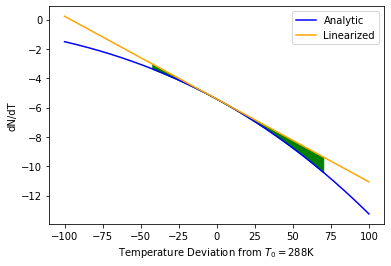

In [ ]:
t0 = 288

def linear_approx(t0=288, dt=100, sigma=sigma, S0=S0):
    dt_steps = np.linspace(-dt, dt, 1000)
    dndt_analytic = -4 * sigma * (dt_steps + t0) ** 3
    dndt_linearized = -4 * sigma * t0 ** 3 - dt_steps * 12 * sigma * t0 ** 2
    return dt_steps, dndt_analytic, dndt_linearized

dt, dndt_an, dndt_lin = linear_approx(t0=t0)

plt.plot(dt, dndt_an, ls='solid', color='blue', label='Analytic')
plt.plot(dt, dndt_lin, ls='solid', color='orange', label='Linearized')
plt.fill_between(dt, dndt_lin, dndt_an, where=np.abs((dndt_lin-dndt_an)/dndt_an) <= 0.1, color='green')
plt.legend()
plt.xlabel(f'Temperature Deviation from $T_0={t0}$K')
plt.ylabel('dN/dT')

# Old Exercise 2

Emissivity 0.6000, Eq. Temp: 290.7511K, Difference: 2.7511K
Emissivity 0.4500, Eq. Temp: 253.9332K, Difference: -34.0668K
Emissivity 0.5250, Eq. Temp: 264.3903K, Difference: -23.6097K
Emissivity 0.5625, Eq. Temp: 282.6255K, Difference: -5.3745K
Emissivity 0.5813, Eq. Temp: 288.1676K, Difference: 0.1676K
Emissivity 0.5719, Eq. Temp: 286.0280K, Difference: -1.9720K
Emissivity 0.5766, Eq. Temp: 287.2143K, Difference: -0.7857K
Emissivity 0.5789, Eq. Temp: 287.7154K, Difference: -0.2846K
Emissivity 0.5801, Eq. Temp: 287.9471K, Difference: -0.0529K
Emissivity 0.5807, Eq. Temp: 288.0587K, Difference: 0.0587K
Emissivity 0.5804, Eq. Temp: 288.0032K, Difference: 0.0032K
Required emissivity for 288K: 0.5804
Emissivity 0.6000, Eq. Temp: 290.7511K, Difference: 0.2511K
Emissivity 0.4500, Eq. Temp: 253.9332K, Difference: -36.5668K
Emissivity 0.5250, Eq. Temp: 264.3903K, Difference: -26.1097K
Emissivity 0.5625, Eq. Temp: 282.6255K, Difference: -7.8745K
Emissivity 0.5813, Eq. Temp: 288.1676K, Differenc

Text(0, 0.5, 'Equilibrium temperaure [K]')

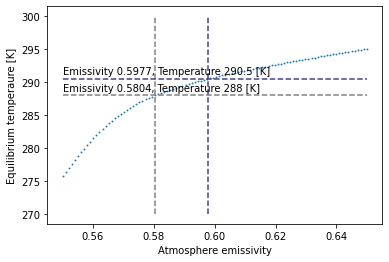

In [ ]:
t_targets = [288, 290.5]
target_emis = np.zeros_like(t_targets)
colors = ['gray', 'darkslateblue']

for i, t_target in enumerate(t_targets):

    emss_low = 0.3
    emss_high = 0.9

    t_dif = 10 # arbitrary starting value, should be higher than value in while condition

    while np.abs(t_dif) > 0.01:
        new_emss = 0.5*(emss_low+emss_high)
        model = ESM(initial_state=255.0, emissivity=new_emss, active_components=1)
        output = model.integrate(sim_time=25., update_state=True, verbose=False)

        t_dif = output['Ts'] - t_target
        print(f"Emissivity {new_emss:.4f}, Eq. Temp: {output['Ts']:.4f}K, Difference: {t_dif:.4f}K")

        if t_dif > 0:
            emss_high = new_emss
        else:
            emss_low = new_emss

    print(f"Required emissivity for {t_target}K: {new_emss:.4f}")
    target_emis[i] = new_emss

emss_arr = np.linspace(0.55, 0.65, 100)

temp_eq = np.empty_like(emss_arr)

for i, emss in enumerate(emss_arr):

    model = ESM(initial_state=255.0, emissivity=emss, active_components=1)
    output = model.integrate(sim_time=25., update_state=True, verbose=False)
    temp_eq[i] = output['Ts']


# tau = 1.0 - 0.5 * emss_arr
plt.scatter(emss_arr, temp_eq, s=0.8)

for i, t in enumerate(t_targets):
    plt.hlines(t, emss_arr.min(), emss_arr.max(), colors=colors[i], linestyles='dashed', label='')
    plt.vlines(target_emis[i], 270., 300., colors=colors[i], linestyles='dashed', label='')
    plt.annotate(f'Emissivity {target_emis[i]:.4f}, Temperature {t} [K]', xy=(emss_arr.min(), t+0.7), xycoords='data')

plt.xlabel("Atmosphere emissivity")
plt.ylabel("Equilibrium temperaure [K]")


# Old Exercise 3 and some general tests

Running [Atmosphere, Ocean, Carbon] :  1
Surface temperature:  275.0  [K]
Ocean temperature:  265.0  [K]
Surface albedo:  0.3  [-]
Land albedo:  0.3  [-]
CO2:  0.0  [ppmv]
ASR:  238.91  [W/m^2]
OLR:  227.00760897359615  [W/m^2]
NRI:  11.902391026403848  [W/m^2]
DSI:  32.0  [W/m^2]
-------------------------------------------------------------------
Running [Atmosphere, Ocean, Carbon] :  1
Surface temperature:  275.0  [K]
Ocean temperature:  265.0  [K]
Surface albedo:  0.3  [-]
Land albedo:  0.3  [-]
CO2:  280.0  [ppmv]
ASR:  238.91  [W/m^2]
OLR:  196.5797451164822  [W/m^2]
NRI:  42.330254883517796  [W/m^2]
DSI:  32.0  [W/m^2]
-------------------------------------------------------------------
Running [Atmosphere, Ocean, Carbon] :  1
Surface temperature:  275.0  [K]
Ocean temperature:  265.0  [K]
Surface albedo:  0.3  [-]
Land albedo:  0.3  [-]
CO2:  420.0  [ppmv]
ASR:  238.91  [W/m^2]
OLR:  194.39023353269812  [W/m^2]
NRI:  44.51976646730188  [W/m^2]
DSI:  32.0  [W/m^2]


ValueError: ignored

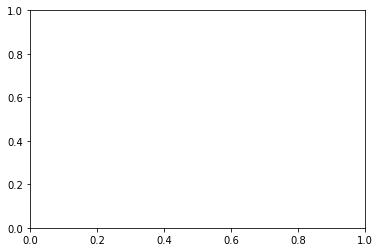

In [ ]:
model = ESM(initial_state={'Ts':275.0, 'Ca':0.}, use_constant_albedo_land=True, albedo_atm=0.0, active_components=1)

model.model_info()

time, output = model.integrate(sim_time=20., out_freq=.1, update_state=False)
temperature_0 = output['Ts']

print('-------------------------------------------------------------------')

model = ESM(initial_state={'Ts':275.0, 'Ca':280.}, use_constant_albedo_land=True, albedo_atm=0.0, active_components=1)

model.model_info()

time, output = model.integrate(sim_time=20., out_freq=.1)
temperature_1 = output['Ts']

print('-------------------------------------------------------------------')

model = ESM(initial_state={'Ts':275.0, 'Ca':420.}, use_constant_albedo_land=True, albedo_atm=0.0, active_components=1)

model.model_info()

time, output = model.integrate(sim_time=20., out_freq=.1)
temperature_2 = output['Ts']

plt.plot(time, temperature_0, ls='solid', color='blue', label="1 ppmv")
plt.plot(time, temperature_1, ls='solid', color='orange', label="280 ppmv")
plt.plot(time, temperature_2, ls='solid', color='purple', label="420 ppmv")

plt.xlabel('Years')
plt.ylabel('Temperature [K]')
plt.legend(title='CO2')

In [ ]:
model.integrate(sim_time=20., out_freq=.1, update_state=True)

(array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
         3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
         4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
         5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
         6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
         7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
         8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
         9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
        11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
        12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
        13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
        14.3, 14.4, 14.5, 14.6, 14.7, 

Running stand-alone atmosphere:  True
Surface temperature:  255.0  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.5203505387443385  [-]
Land albedo:  0.5189512824004178  [-]
CO2:  400.0  [ppmv]
ASR:  163.7043611265573  [W/m^2]
OLR:  135.47638754405622  [W/m^2]
NRI:  28.22797358250108  [W/m^2]
DSI:  32.0  [W/m^2]
-------------------------------------------------------------------
Running stand-alone atmosphere:  True
Surface temperature:  255.0  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.5203505387443385  [-]
Land albedo:  0.5189512824004178  [-]
CO2:  400.0  [ppmv]
ASR:  163.7043611265573  [W/m^2]
OLR:  135.47638754405622  [W/m^2]
NRI:  28.22797358250108  [W/m^2]
DSI:  32.0  [W/m^2]
Running stand-alone atmosphere:  True
Surface temperature:  255.0  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.5203505387443385  [-]
Land albedo:  0.5189512824004178  [-]
CO2:  400.0  [ppmv]
ASR:  163.7043611265573  [W/m^2]
OLR:  135.47638754405622  [W/m^2]
NRI:  28.2279735825010

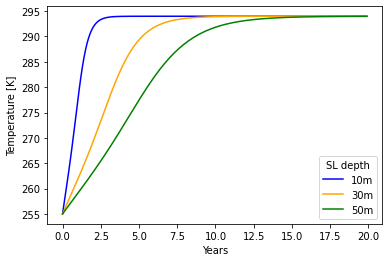

In [ ]:
model = ESM(initial_state=255.0, depth_s=10.)

model.model_info()

time, temperature_0 = model.integrate(sim_time=20., out_freq=.1, update_state=False, verbose=False)

print('-------------------------------------------------------------------')
model.model_info()


model = ESM(initial_state=255.0, depth_s=30.)

model.model_info()

time, temperature_1 = model.integrate(sim_time=20., out_freq=.1, update_state=False, verbose=False)

print('-------------------------------------------------------------------')
model.model_info()


model = ESM(initial_state=255.0, depth_s=50.)

model.model_info()

time, temperature_2 = model.integrate(sim_time=20., out_freq=.1, update_state=False, verbose=False)

print('-------------------------------------------------------------------')
model.model_info()

plt.plot(time, temperature_0, ls='solid', color='blue', label="10m")
plt.plot(time, temperature_1, ls='solid', color='orange', label="30m")
plt.plot(time, temperature_2, ls='solid', color='green', label="50m")

plt.xlabel('Years')
plt.ylabel('Temperature [K]')
plt.legend(title='SL depth')

Running stand-alone atmosphere:  True
Surface temperature:  255.0  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.5203505387443385  [-]
Land albedo:  0.5189512824004178  [-]
CO2:  400  [ppmv]
ASR:  163.7043611265573  [W/m^2]
OLR:  135.47638754405622  [W/m^2]
NRI:  28.22797358250108  [W/m^2]
DSI:  32.0  [W/m^2]
-------------------------------------------------------------------
Running stand-alone atmosphere:  True
Surface temperature:  255.0  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.5203505387443385  [-]
Land albedo:  0.5189512824004178  [-]
CO2:  400  [ppmv]
ASR:  163.7043611265573  [W/m^2]
OLR:  135.47638754405622  [W/m^2]
NRI:  28.22797358250108  [W/m^2]
DSI:  32.0  [W/m^2]
Running stand-alone atmosphere:  True
Surface temperature:  255.0  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.5203505387443385  [-]
Land albedo:  0.5189512824004178  [-]
ASR:  163.7043611265573  [W/m^2]
OLR:  167.83029609843933  [W/m^2]
NRI:  -4.125934971882032  [W/m^2]
DSI:  32.0  

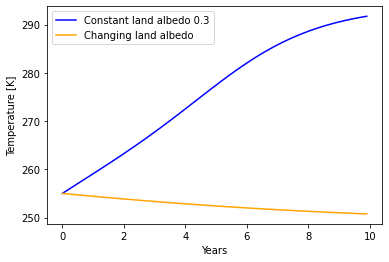

In [ ]:
model = ESM(initial_state=255.0, co2=400)

model.model_info()

time, temperature_0 = model.integrate(sim_time=10., out_freq=.1, update_state=False, verbose=False)

print('-------------------------------------------------------------------')
model.model_info()


model = ESM(initial_state=255.0, co2=0)

model.model_info()

time, temperature_1 = model.integrate(sim_time=10., out_freq=.1, update_state=False, verbose=False)

print('-------------------------------------------------------------------')
model.model_info()


plt.plot(time, temperature_0, ls='solid', color='blue', label="Constant land albedo 0.3")
plt.plot(time, temperature_1, ls='solid', color='orange', label="Changing land albedo")

plt.xlabel('Years')
plt.ylabel('Temperature [K]')
plt.legend()

# Albedo Exercise 1

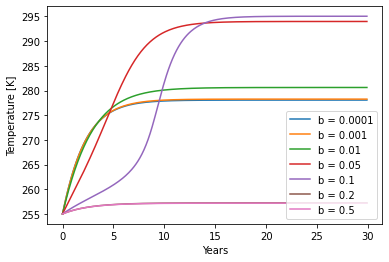

In [ ]:
for param_b in [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5]:
  model = ESM(initial_state=255.0, albedo_b=param_b)

  time, temperature_0 = model.integrate(sim_time=30., out_freq=.1, update_state=False, verbose=False)

  plt.plot(time, temperature_0, ls='solid', label=f"b = {param_b}")

plt.xlabel('Years')
plt.ylabel('Temperature [K]')
plt.legend()

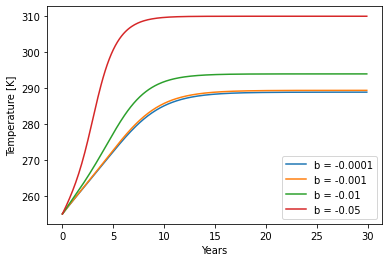

In [ ]:
for param_aco2 in [-0.0001, -0.001, -0.01, -0.05]:
  model = ESM(initial_state=255.0, albedo_carbon_coeff=param_aco2)

  time, temperature_0 = model.integrate(sim_time=30., out_freq=.1, update_state=False, verbose=False)

  plt.plot(time, temperature_0, ls='solid', label=f"b = {param_aco2}")

plt.xlabel('Years')
plt.ylabel('Temperature [K]')
plt.legend()

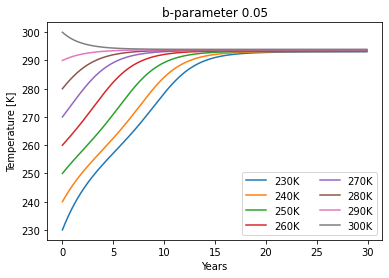

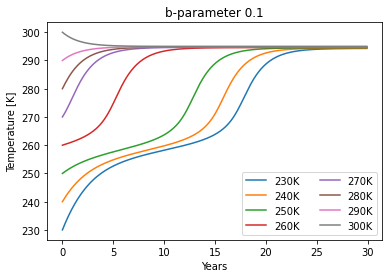

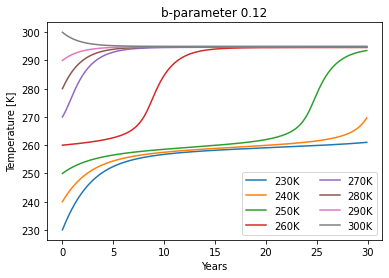

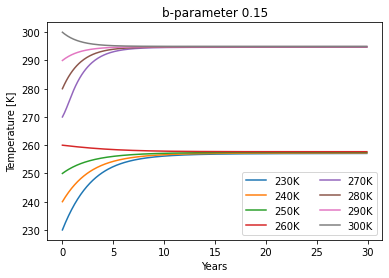

In [ ]:
for albedo_b in [0.05, 0.1, 0.12, 0.15]:
    for t_init in np.arange(230,301,10):
        model = ESM(initial_state=(t_init, t_init-10), albedo_b=albedo_b)

        time, temperature_0 = model.integrate(sim_time=30., out_freq=.1, update_state=False, verbose=False)

        plt.plot(time, temperature_0[:, 0], ls='solid', label=f"{t_init}K")


    plt.xlabel('Years')
    plt.ylabel('Temperature [K]')
    plt.title(f'b-parameter {albedo_b}')
    plt.legend(ncol=2)
    plt.show()

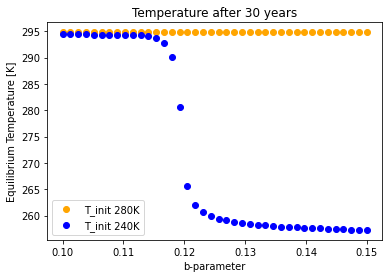

In [ ]:
colors = ['orange', 'blue', 'green']
for i, t_init in enumerate([280, 240]):
    for j, albedo_b in enumerate(np.linspace(0.1, 0.15, 40)):

        model = ESM(initial_state=(t_init, t_init-10), albedo_b=albedo_b)

        time, temperature_0 = model.integrate(sim_time=30., out_freq=.1, update_state=False, verbose=False)

        if j == 0:
            plt.scatter(albedo_b, temperature_0[-1, 0], c=colors[i], ls='solid', label=f"T_init {t_init}K")
        else:
            plt.scatter(albedo_b, temperature_0[-1, 0], c=colors[i], ls='solid')


plt.xlabel('b-parameter')
plt.ylabel('Equilibrium Temperature [K]')
plt.title('Temperature after 30 years')
plt.legend()
plt.show()

# Albedo Exercise 2

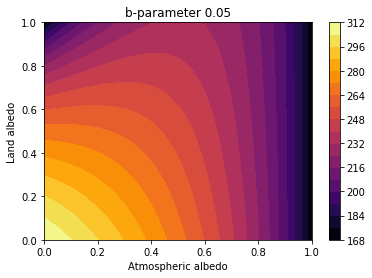

In [ ]:
albedos_atm = np.arange(0,1.01,0.05)
albedos_land = np.arange(0,1.01,0.05)
b_param = 0.05

tequis = np.zeros((len(albedos_atm), len(albedos_land)))

for i, albedo_atm in enumerate(albedos_atm):
    for j, albedo_land in enumerate(albedos_land):
        model = ESM(initial_state=255., use_constant_albedo_icefree=True, use_constant_albedo_land=True, albedo_land=albedo_land, albedo_atm=albedo_atm, albedo_b=b_param)

        time, temperature_0 = model.integrate(sim_time=30., out_freq=.1, update_state=False, verbose=False)

        tequis[i, j] = temperature_0[-1]

plt.contourf(albedos_atm, albedos_land, tequis.T, cmap='inferno', levels=20)
plt.colorbar()

plt.xlabel('Atmospheric albedo')
plt.ylabel('Land albedo')
plt.title(f'b-parameter {b_param}')
plt.show()

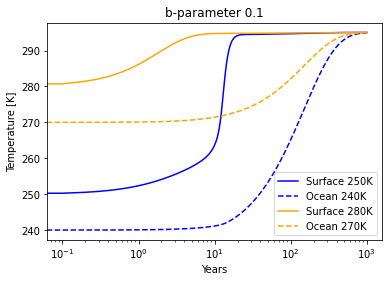

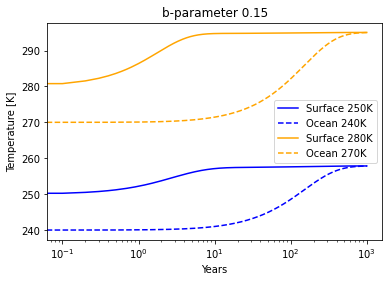

In [ ]:
colors = ['blue', 'orange']

for albedo_b in [0.1, 0.15]:
    for i, t_init in enumerate([250, 280]):
        model = ESM(initial_state=(t_init, t_init-10), albedo_b=albedo_b)

        time, temperature_0 = model.integrate(sim_time=1000., out_freq=.1, update_state=False, verbose=False)

        plt.semilogx(time, temperature_0[:,0], color = colors[i], ls='solid', label=f"Surface {t_init}K")
        plt.semilogx(time, temperature_0[:,1], color = colors[i], ls='--', label=f"Ocean {t_init-10}K")


    plt.xlabel('Years')
    plt.ylabel('Temperature [K]')
    plt.title(f'b-parameter {albedo_b}')
    plt.legend()
    plt.show()

# Deep Ocean Exercise 5

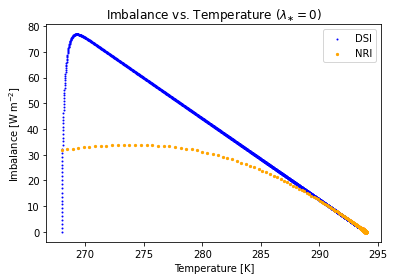

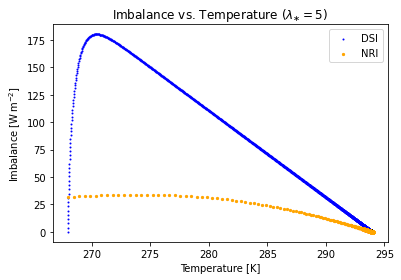

In [ ]:
model = ESM(initial_state=(268., 268.))

time, temperature_0 = model.integrate(sim_time=1000., out_freq=.1, update_state=False, verbose=False)

nri = np.zeros(len(temperature_0))
dsi = np.zeros(len(temperature_0))

for i, (ts, td) in enumerate(temperature_0):
    nri[i] = model.compute_NRI(ts)
    dsi[i] = model.compute_DSI(ts, td)

plt.scatter(temperature_0[:,1], dsi, color='blue', s=1, label='DSI')
plt.scatter(temperature_0[:,0], nri, color='orange', s=5, label='NRI')

plt.xlabel('Temperature [K]')
plt.ylabel('Imbalance [$\mathrm{W}\,\mathrm{m}^{-2}$]')
plt.title(r'Imbalance vs. Temperature ($\lambda_{\ast}=0$)')
plt.legend()
plt.show()


model = ESM(initial_state=(268., 268.), transient_rad_resp=5)

time, temperature_0 = model.integrate(sim_time=1000., out_freq=.1, update_state=False, verbose=False)

nri = np.zeros(len(temperature_0))
dsi = np.zeros(len(temperature_0))

for i, (ts, td) in enumerate(temperature_0):
    nri[i] = model.compute_NRI(ts)
    dsi[i] = model.compute_DSI(ts, td)

plt.scatter(temperature_0[:,1], dsi, color='blue', s=1, label='DSI')
plt.scatter(temperature_0[:,0], nri, color='orange', s=5, label='NRI')

plt.xlabel('Temperature [K]')
plt.ylabel('Imbalance [$\mathrm{W}\,\mathrm{m}^{-2}$]')
plt.title(r'Imbalance vs. Temperature ($\lambda_{\ast}=5$)')
plt.legend()
plt.show()

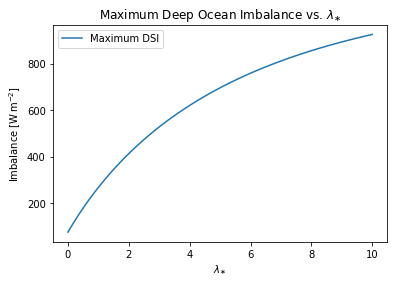

In [ ]:
n = 50
dsi_max = np.zeros(n)

for j, lambda_star in enumerate(np.linspace(0, 100, n)):
    model = ESM(initial_state=(268., 268.), transient_rad_resp=lambda_star)

    time, temperature_0 = model.integrate(sim_time=1000., out_freq=.1, update_state=False, verbose=False)

    dsi = np.zeros(len(temperature_0))

    for i, (ts, td) in enumerate(temperature_0):
        dsi[i] = model.compute_DSI(ts, td)

    dsi_max[j] = np.max(dsi)

plt.plot(np.linspace(0, 10, n), dsi_max, label='Maximum DSI')

plt.xlabel(r'$\lambda_{\ast}$')
plt.ylabel('Imbalance [$\mathrm{W}\,\mathrm{m}^{-2}$]')
plt.title(r'Maximum Deep Ocean Imbalance vs. $\lambda_{\ast}$')
plt.legend()
plt.show()

# Deep Ocean Exercise 6

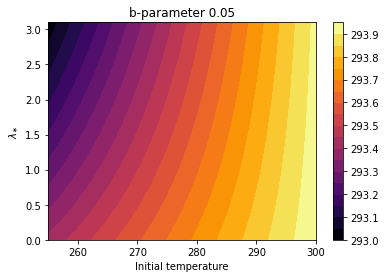

In [ ]:
initial_state = np.linspace(255.0, 300., 25)
lambda_ast = np.linspace(0.0, 3.1, 25)
b_param = 0.05

tequis = np.zeros((len(lambda_ast), len(initial_state)))

for i, tstart in enumerate(initial_state):
    for j, lbd_ast in enumerate(lambda_ast):

        model = ESM(initial_state=[tstart, tstart-10.0], transient_rad_resp=lbd_ast)

        time, Ts = model.integrate(sim_time=30., out_freq=.1, update_state=False, verbose=False)

        tequis[i, j] = Ts[-1, 0]

plt.contourf(initial_state, lambda_ast, tequis.T, cmap='inferno', levels=20)
plt.colorbar()

plt.xlabel('Initial temperature')
plt.ylabel(r'$\lambda_{\ast}$')
plt.title(f'b-parameter {b_param}')
plt.show()

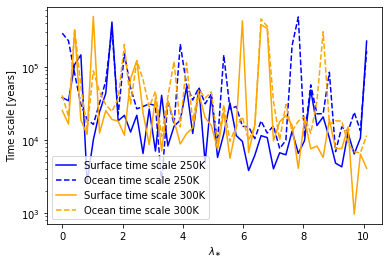

In [ ]:
colors = ['blue', 'orange', 'black']
rad_response = np.linspace(0., 10.1, 50)

eq_timescale=500000.

time_scale_s = np.zeros_like(rad_response)
time_scale_d = np.zeros_like(rad_response)

for i, t_init in enumerate([250, 300]):

    for j, lbd_ast in enumerate(rad_response):

        model = ESM(initial_state=(t_init, t_init), transient_rad_resp=lbd_ast, mixing_scale=6.0)

        time, temp = model.integrate(sim_time=eq_timescale, out_freq=.1, update_state=False, verbose=False)

        _, id_s, _ = np.intersect1d( temp[:, 0], temp[-1, 0], return_indices=True)
        time_scale_s[j] = time[id_s[0]]

        _, id_d, _, = np.intersect1d( temp[:, 1], temp[-1, 1], return_indices=True)
        time_scale_d[j] = time[id_d[0]]

    plt.semilogy(rad_response, time_scale_s, color = colors[i], ls='solid', label=f"Surface time scale {t_init}K")
    plt.semilogy(rad_response, time_scale_d, color = colors[i], ls='--', label=f"Ocean time scale {t_init}K")

plt.ylabel('Time scale [years]')
plt.xlabel(r'$\lambda_{\ast}$')
plt.title('')
plt.legend()
plt.show()

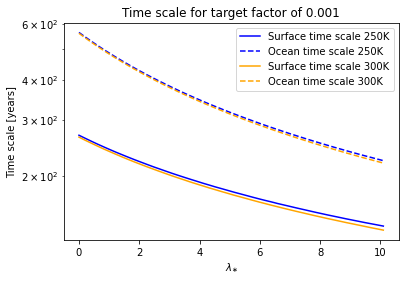

In [ ]:
colors = ['blue', 'orange', 'black']
rad_response = np.linspace(0., 10.1, 50)

eq_timescale=5000.
target_factor=0.001

time_scale_s = np.zeros_like(rad_response)
time_scale_d = np.zeros_like(rad_response)

for i, t_init in enumerate([250, 300]):

    for j, lbd_ast in enumerate(rad_response):

        model = ESM(initial_state=(t_init, t_init), transient_rad_resp=lbd_ast, mixing_scale=6.0)

        time, temp = model.integrate(sim_time=eq_timescale, out_freq=.1, update_state=False, verbose=False)

        temp_s = temp[:, 0]
        temp_d = temp[:, 1]
        
        time_scale_s[j] = time[np.abs(temp_s - temp_s[-1]) < np.abs(temp_s[0] - temp_s[-1])*target_factor][0]
        time_scale_d[j] = time[np.abs(temp_d - temp_d[-1]) < np.abs(temp_d[0] - temp_d[-1])*target_factor][0]

    plt.semilogy(rad_response, time_scale_s, color = colors[i], ls='solid', label=f"Surface time scale {t_init}K")
    plt.semilogy(rad_response, time_scale_d, color = colors[i], ls='--', label=f"Ocean time scale {t_init}K")

plt.ylabel('Time scale [years]')
plt.xlabel(r'$\lambda_{\ast}$')
plt.title(f'Time scale for target factor of {target_factor}')
plt.legend()
plt.show()

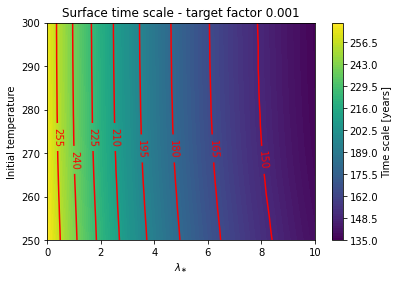

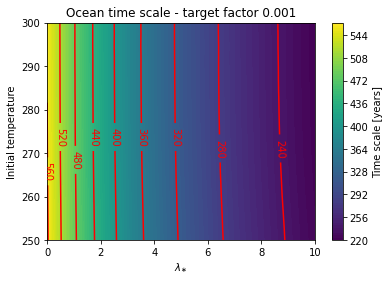

In [ ]:
rad_response = np.linspace(0., 10., 50)
t_inits = np.linspace(250., 300., 20)

eq_timescale=1000.
target_factor=0.001

time_scale_s = np.zeros((len(t_inits), len(rad_response)))
time_scale_d = np.zeros((len(t_inits), len(rad_response)))

for i, t_init in enumerate(t_inits):

    for j, lbd_ast in enumerate(rad_response):

        model = ESM(initial_state=(t_init, t_init), transient_rad_resp=lbd_ast, mixing_scale=6.0)

        time, temp = model.integrate(sim_time=eq_timescale, out_freq=.1, update_state=False, verbose=False)

        temp_s = temp[:, 0]
        temp_d = temp[:, 1]
        
        time_scale_s[i, j] = time[np.abs(temp_s - temp_s[-1]) < np.abs(temp_s[0] - temp_s[-1])*target_factor][0]
        time_scale_d[i, j] = time[np.abs(temp_d - temp_d[-1]) < np.abs(temp_d[0] - temp_d[-1])*target_factor][0]

plt.contourf(rad_response, t_inits, time_scale_s, cmap='viridis', levels=100)
plt.colorbar(label='Time scale [years]')
contour = plt.contour(rad_response, t_inits, time_scale_s, colors='red', levels=10)
plt.clabel(contour, colors='red', fmt='%1.0f')

plt.xlabel(r'$\lambda_{\ast}$')
plt.ylabel('Initial temperature')
plt.title(f'Surface time scale - target factor {target_factor}')
plt.show()

plt.contourf(rad_response, t_inits, time_scale_d, cmap='viridis', levels=100)
plt.colorbar(label='Time scale [years]')
contour = plt.contour(rad_response, t_inits, time_scale_d, colors='red', levels=10)
plt.clabel(contour, colors='red', fmt='%1.0f')

plt.xlabel(r'$\lambda_{\ast}$')
plt.ylabel('Initial temperature')
plt.title(f'Ocean time scale - target factor {target_factor}')
plt.show()